# Library Needed for Analysis

In [1]:
import scanpy as sc
import scvi
import warnings
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Lambda, Input, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.layers import Layer, Activation
from tensorflow.keras import metrics
import tensorflow as tf
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

/u/home/c/chunter/.local/lib/python3.9/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)
2023-07-27 20:10:43.766773: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 20:11:02.348103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load in the Data and Subset for Marker Genes

In [3]:
# Full Data
#path = '/u/project/cluo/heffel/joint_v4/CTX_all_ages_mCG-CH.h5ad'
#adata = sc.read(path) 
# Method for subsetting highly variable features
sc.tl.rank_genes_groups(adata, 'L4', n_genes = 1000,rankby_abs=True) 
markers = [] 
for i in range(27): 
    for j in range(1000): 
        if adata.uns['rank_genes_groups']['names'][j][i] not in markers:
            markers.append(adata.uns['rank_genes_groups']['names'][j][i]) 
adata=adata[:,markers]

In [4]:
adata

View of AnnData object with n_obs × n_vars = 29691 × 5649
    obs: 'Sample', 'region', 'mCCC/CCC', 'mCH/CH', 'mCG/CG', 'L2', 'L3', 'age_groups', 'temp_clust', 'log2_age', 'age', 'leiden', 'L5', 'mSample', 'TotalInt', 'age_groups+', 'L4', 'L1', 'oldL2', 'oldL3', 'oldL4', 'oldmCCC/CCC', 'oldmCH/CH', 'oldmCG/CG', 'oldSample', 'oldregion', 'oldage_groups', 'oldTotalInt', 'sL3', 'asL3'
    uns: 'L2_colors', 'L5_colors', 'age_groups_colors', 'leiden', 'neighbors', 'pca', 'region_colors', 'umap', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Split the Data into Training and Testing 

In [ ]:
x = np.array(adata.X)
x_train, x_test = train_test_split(x, test_size=0.33, random_state=42,shuffle=True)
print('-'*50)
print('Training Data Shape', x_train.shape)
print('-'*50)
print('Testing Data Shape', x_test.shape)
print('-'*50)

# Build the Gaussian Mixture Variational Autoencoder

In [ ]:
# Library needed
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K

# Define the hyperparameters
latent_dim = 34 # Bottleneck dimensions
original_dim = x_train.shape[1] # The input data
epochs = 30 # Number of times we iterate through the entire dataset
batch_size = 50 # Number of samples per training round until entire dataset

class scVAE(keras.Model): # Define our single cell variational autoencoder
    def __init__(self, latent_dim, original_dim, epochs=10, batch_size=128,
                 optimizer=keras.optimizers.Adam(learning_rate=0.001),
                 recon_loss_function=tf.keras.losses.MeanSquaredError()):  # Initialize the model with the given parameters
        super(scVAE, self).__init__()
        # Initialization parameters
        self.latent_dim = latent_dim
        self.original_dim = original_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.recon_loss_function = recon_loss_function
        # Define the construction of the encoder with optimizer and loss
        self.encoder = self.generate_encoder()
        self.encoder.compile(optimizer=optimizer, loss=self.vae_loss)
        # Define the construction of the decoder with optimizer and loss
        self.decoder = self.generate_decoder()
        self.decoder.compile(optimizer=optimizer, loss=self.vae_loss)
        # Construction of vae loss 
        self.mu = None
        self.sigma = None
        self.kappa = 1 
    # VAE loss
    def vae_loss(self, y_true, y_pred): # Define the vae_loss function
        recon = self.recon_loss_function(y_true, y_pred) # Reconstruction loss is MSE of observed values vs. predicted
        if self.mu is None or self.sigma is None:  # Both mu and sigma are initialized to be None
            self.mu = K.zeros_like(y_true)  # Return zero tensor with shape of true values
            self.sigma = K.zeros_like(y_true)  # Return zero tensor with shape of predicted values
        # Calculate the kl divergence
        kl = K.mean(0.5 * K.sum(K.exp(self.sigma) + K.square(self.mu) - 1. - self.sigma, axis=1))
        # Scale down the contribution of the KL loss to prioritize the reconstruction accuracy 
        return recon, self.kappa * kl / 260 
    # Sampling function
    def sample_z(self, args): # Define the sampling function (samples from the latent variable Z)
        vae_mu, vae_sigma = args # The arguments of sample_z are the mu vector and sigma vector from encoder
        # epsilon is a random distributed tensor that has the shape of vae_mu and has mean 0 and std of 1
        eps = K.random_normal(shape=(K.shape(vae_mu)[0], K.shape(vae_mu)[1]), mean=0., stddev=1., seed=42)
        # Generate a sample from the latent space, Z. 
        return vae_mu + K.exp(vae_sigma / 2) * eps
    # KL loss
    def kl_loss(self): # Define the Kullback-Leibler Divegence Loss
        return K.mean(0.5 * K.sum(K.exp(self.sigma) + K.square(self.mu) - 1. - self.sigma, axis=1))
    # The encoder model
    def generate_encoder(self):
        Encoder_Inputs = keras.Input(shape=(self.original_dim,))
        Hidden_1 = layers.Dense(300, activation='relu')(Encoder_Inputs)
        Hidden_2 = layers.Dense(200, activation='relu')(Hidden_1)
        Hidden_3 = layers.Dense(180, activation = 'relu')(Hidden_2)
        vae_mu = layers.Dense(self.latent_dim, activation='linear')(Hidden_3)
        vae_sigma = layers.Dense(self.latent_dim, activation='linear')(Hidden_3)
        return Model(Encoder_Inputs, [vae_mu, vae_sigma], name='Encoder')
    # This is the same as the function above.
    def perform_sampling(self, args):
        vae_mu, vae_sigma = args
        eps = K.random_normal(shape=(K.shape(vae_mu)[0], K.shape(vae_mu)[1]), mean=0., stddev=1., seed=42)
        return vae_mu + K.exp(vae_sigma / 2) * eps
    # Generate the decoder
    def generate_decoder(self):
        latent_input = keras.Input(shape=(self.latent_dim,))
        hidden_layer = layers.Dense(200, activation='relu')(latent_input)
        out_prediction = layers.Dense(self.original_dim, activation='linear', name='Out_Prediction')(hidden_layer)
        return Model(latent_input, out_prediction, name='decoder')
    # Define the prediction function which returns the reconstructed
    def predict(self, x):
        mu, sigma = self.encoder.predict(x) # Connect the encoder to the latent space
        z = self.perform_sampling([mu, sigma]) # Sample from the latent variable Z
        x_pred = self.decoder.predict(z) # Predict what the input was from latent variable Z
        return x_pred # Return the reconstructed or predicted value from model
    # Custom Training function
    def train(self, x_train, x_val):
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train)).shuffle(len(x_train)).batch(self.batch_size)
        val_dataset = tf.data.Dataset.from_tensor_slices((x_val, x_val)).batch(self.batch_size)

        train_losses = []
        val_losses = []
        
        print('='*50)
        
        for epoch in range(self.epochs):
            print(f"Epoch {epoch+1}/{self.epochs}")

            # Training loop
            train_loss = 0.0
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    mu, sigma = self.encoder(x_batch_train, training=True)
                    z = self.perform_sampling([mu, sigma])
                    x_pred = self.decoder(z, training=True)
                    recon_loss, kl_loss = self.vae_loss(x_batch_train, x_pred)
                    loss = recon_loss + kl_loss

                gradients = tape.gradient(loss, self.trainable_variables)
                self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

                train_loss += loss.numpy()

            train_loss /= (step + 1)
            train_losses.append(train_loss)

            # Validation loop
            val_loss = 0.0
            for x_batch_val, y_batch_val in val_dataset:
                mu_val, sigma_val = self.encoder(x_batch_val, training=False)
                z_val = self.perform_sampling([mu_val, sigma_val])
                x_pred_val = self.decoder(z_val, training=False)
                recon_loss_val, kl_loss_val = self.vae_loss(x_batch_val, x_pred_val)
                loss_val = recon_loss_val + kl_loss_val

                val_loss += loss_val.numpy()

            val_loss /= len(val_dataset)
            val_losses.append(val_loss)
            
            print('='*50)

            print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
            
            print('='*50)

        return train_losses, val_losses

    
class GaussianMixtureVAE(scVAE):
    def __init__(self, latent_dim, original_dim, n_centroids, epochs=10, batch_size=128,
                 optimizer=keras.optimizers.Adam(learning_rate=0.001),
                 recon_loss_function=tf.keras.losses.MeanSquaredError()):
        super(GaussianMixtureVAE, self).__init__(latent_dim, original_dim, epochs, batch_size, optimizer, recon_loss_function)
        self.n_centroids = n_centroids
        self.pi = None
        self.mu_c = None
        self.var_c = None

        self.encoder = self.generate_encoder()
        self.encoder.compile(optimizer=optimizer, loss=self.vae_loss)
        # Define the construction of the decoder with optimizer and loss
        self.decoder = self.generate_decoder()
        self.decoder.compile(optimizer=optimizer, loss=self.vae_loss)
        # Construction of vae loss 

    def vae_loss(self, y_true, y_pred):
        recon_loss, kl_loss = super().vae_loss(y_true, y_pred)

        if self.pi is None or self.mu_c is None or self.var_c is None:
            self.pi = K.ones((self.n_centroids,)) / self.n_centroids
            self.mu_c = K.zeros((self.latent_dim, self.n_centroids))
            self.var_c = K.ones((self.latent_dim, self.n_centroids))

        return recon_loss, kl_loss + self.gmm_kl_loss()

    def gmm_kl_loss(self):
        var_c_eps = K.clip(self.var_c, K.epsilon(), None)
        logvar_c = K.log(var_c_eps)
        kl_loss = -0.5 * K.mean(K.sum(1 + logvar_c - K.square(self.mu_c) - var_c_eps, axis=-1), axis=0)
        return kl_loss

    def generate_encoder(self):
        encoder_inputs = keras.Input(shape=(self.original_dim,))
        hidden_1 = layers.Dense(300, activation='relu')(encoder_inputs)
        hidden_2 = layers.Dense(200, activation='relu')(hidden_1)
        hidden_3 = layers.Dense(180, activation='relu')(hidden_2)
        vae_mu = layers.Dense(self.latent_dim, activation='linear')(hidden_3)
        vae_logvar = layers.Dense(self.latent_dim, activation='linear')(hidden_3)
        return Model(encoder_inputs, [vae_mu, vae_logvar], name='Encoder')

    def perform_sampling(self, args):
        vae_mu, vae_logvar = args
        eps = K.random_normal(shape=(K.shape(vae_mu)[0], K.shape(vae_mu)[1]), mean=0., stddev=1., seed=42)
        return vae_mu + K.exp(0.5 * vae_logvar) * eps

    def generate_decoder(self):
        latent_input = keras.Input(shape=(self.latent_dim,))
        hidden_layer = layers.Dense(200, activation='relu')(latent_input)
        out_prediction = layers.Dense(self.original_dim, activation='linear', name='Out_Prediction')(hidden_layer)
        return Model(latent_input, out_prediction, name='Decoder')

    def get_gamma(self, z):
        z = K.expand_dims(z, axis=2)
        pi = K.repeat_elements(K.expand_dims(self.pi, axis=0), K.shape(z)[0], axis=0)
        mu_c = K.repeat_elements(K.expand_dims(self.mu_c, axis=0), K.shape(z)[0], axis=0)
        var_c = K.repeat_elements(K.expand_dims(self.var_c, axis=0), K.shape(z)[0], axis=0)
        p_c_z = K.exp(K.log(pi) - K.sum(0.5 * K.log(2 * math.pi * var_c) + K.square(z - mu_c) / (2 * var_c), axis=1))
        gamma = p_c_z / K.sum(p_c_z, axis=1, keepdims=True)
        return gamma, mu_c, var_c, pi
    
latent_dim = 34
original_dim = x_train.shape[1]
n_centroids = 13 # Arbitrary choice 
epochs = 20
batch_size = 50
gmvae = GaussianMixtureVAE(latent_dim, original_dim, n_centroids, epochs, batch_size)

# Train gmVAE

In [ ]:
train_losses, val_losses = gmvae.train(x_train, x_test)

# Visualize the Training Loss vs. Validation Loss 

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Train loss gmVAE')
plt.plot(epochs, val_losses, label='Val loss gmVAE')
plt.xlabel('Epochs')
plt.ylabel('recon_loss + kl_loss')
plt.legend()
plt.show()

# Compare the Reconstructed Data vs. Original Data

In [ ]:
import pandas as pd
reconstructed_1 = gmvae.predict(adata.X)
reconstructed_df = pd.DataFrame(reconstructed_1)
reconstructed_adata = sc.AnnData(reconstructed_df)
sc.pp.neighbors(reconstructed_adata)
sc.tl.leiden(reconstructed_adata)
reconstructed_adata

In [ ]:
# Using sc.pp.highly_variable_genes()
sc.pp.pca(adata)
sc.pl.pca(adata, title ='Original adata pca - Marker Genes', color = 'leiden')
sc.pp.pca(reconstructed_adata)
sc.pl.pca(reconstructed_adata, title = 'gmVAE Reconstructed adata pca -  Marker Genes', color = 'leiden')

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca_original = np.array(pca.fit(adata.X))
pca_original = np.array(pca.transform(adata.X))
pca_reconstructed  = np.array(pca.fit(reconstructed_adata.X))
pca_reconstructed  = np.array(pca.transform(reconstructed_adata.X))
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_original[:,0],pca_original[:,1], marker = ".", alpha = 1, label = "adata pca original")
plt.scatter(pca_reconstructed[:,0], pca_reconstructed[:,1], marker = ".", alpha = 0.3, label = 'reconstructed pca gmVAE')
plt.title('gmVAE: adata Original pca vs. Reconstructed adata pca')
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.legend()

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden', title='UMAP with Leiden (adata_HVG)')

sc.pp.neighbors(reconstructed_adata)
sc.tl.umap(reconstructed_adata )
sc.tl.leiden(reconstructed_adata )
sc.pl.umap(reconstructed_adata , color='leiden',  title='UMAP with Leiden (gmvae_HVG)')

from sklearn.metrics import adjusted_rand_score
cluster_labels_adata_HVG = adata.obs['leiden']
cluster_labels_gmvae_HVG = reconstructed_adata.obs['leiden']
ari_gmvae = adjusted_rand_score(cluster_labels_adata_HVG, cluster_labels_gmvae_HVG)

In [ ]:
from sklearn.metrics import adjusted_rand_score
cluster_labels_adata_HVG = adata.obs['leiden']
cluster_labels_gmvae_HVG = reconstructed_adata.obs['leiden']
ari_gmvae = adjusted_rand_score(cluster_labels_adata_HVG, cluster_labels_gmvae_HVG)
print(ari_gmvae)

# Save the Data For Analysis

622/622 [==============================] - 1s 2ms/step


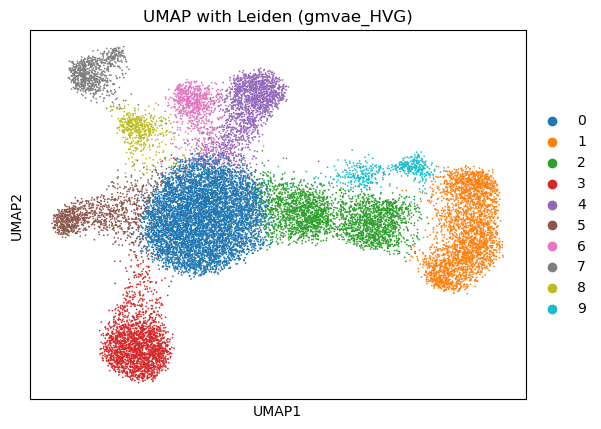

In [26]:
#reconstructed_adata.write('Reconstructed_GMVAE_HVG.h5ad')
# Latent Space
latent_space = gmvae.encoder.predict(x_train)
latent_space = pd.DataFrame(latent_space[0])
latent_space = sc.AnnData(latent_space)


sc.pp.neighbors(latent_space)
sc.tl.umap(latent_space )
sc.tl.leiden(latent_space )
sc.pl.umap(latent_space , color='leiden',  title='UMAP with Leiden (gmvae_HVG)')
